In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score,RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV, cross_val_score, KFold
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb
import lightgbm as lgbm

from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import ElasticNetCV, Lasso
from sklearn.svm import SVR
from mlxtend.regressor import StackingRegressor

In [2]:
train = pd.read_csv('/Users/kostyabykov/Downloads/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/Users/kostyabykov/Downloads/house-prices-advanced-regression-techniques/test.csv')
sample_submission = pd.read_csv('/Users/kostyabykov/Downloads/house-prices-advanced-regression-techniques/sample_submission.csv')

In [3]:
train.sample(11)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
488,489,190,RL,60.0,10800,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2006,ConLD,Normal,160000
344,345,160,RM,36.0,2592,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,85000
352,353,50,RL,60.0,9084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2008,ConLw,Normal,95000
700,701,20,RL,85.0,14331,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2006,WD,Normal,312500
1146,1147,20,RL,NaN,11200,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2006,WD,Normal,180000
1333,1334,50,RM,60.0,7200,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,7,2006,WD,Normal,125500
174,175,20,RL,47.0,12416,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,11,2008,WD,Normal,184000
687,688,160,FV,NaN,5105,Pave,NaN,IR2,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2007,WD,Normal,148800
822,823,60,RL,NaN,12394,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,10,2007,WD,Family,225000
550,551,120,RL,53.0,4043,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,10,2008,COD,Abnorml,140000


### Работа с пропусками

In [4]:
missings = pd.DataFrame(data = train.isnull().sum().sort_values(ascending=False), columns = ['Кол-во пропусков'])
missings['%'] = round(missings['Кол-во пропусков'] / train.shape[0],3)*100
missings.head(20)

,Кол-во пропусков,%
PoolQC,1453,99.5
MiscFeature,1406,96.3
Alley,1369,93.8
Fence,1179,80.8
FireplaceQu,690,47.3
LotFrontage,259,17.7
GarageCond,81,5.5
GarageType,81,5.5
GarageYrBlt,81,5.5
GarageFinish,81,5.5


In [5]:
missings2 = pd.DataFrame(data = test.isnull().sum().sort_values(ascending=False), columns = ['Кол-во пропусков'])
missings2['%'] = round(missings2['Кол-во пропусков'] / test.shape[0],3)*100
missings2.head(20)

,Кол-во пропусков,%
PoolQC,1456,99.8
MiscFeature,1408,96.5
Alley,1352,92.7
Fence,1169,80.1
FireplaceQu,730,50.0
LotFrontage,227,15.6
GarageCond,78,5.3
GarageQual,78,5.3
GarageYrBlt,78,5.3
GarageFinish,78,5.3


Заполним пропущенные значения в столбце LotFrontage регрессией на основе наиболее коррелирующих столбцов LotArea,TotalBsmtSF, 1stFlrSF, GrLivArea

#### Разберемся сначала с train

In [6]:
# Избавимся от пропусках в нужных столбцах
df_inpu = train[['LotFrontage', 'LotArea','TotalBsmtSF', '1stFlrSF', 'GrLivArea']]
df_inpu1 = df_inpu.dropna()

In [7]:
# Выделим пропуски в столбце LotFrontage
missing_LotFrontage = train['LotFrontage'].isnull()
missing_df = pd.DataFrame(train[['LotArea','TotalBsmtSF', '1stFlrSF', 'GrLivArea']][missing_LotFrontage])

In [8]:
X = df_inpu1.drop(['LotFrontage'],axis=1)
y = df_inpu1['LotFrontage']

X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=12345)

In [9]:
lr = LinearRegression()
lr.fit(X_train,y_train)
pred = lr.predict(X_test)
mse1 = mean_squared_error(y_test, pred)
pred = lr.predict(missing_df)

In [10]:
# Дополним таблицу предсказанными значениями
pred = list(pred)
missing_df['LotFrontage'] = pred
missing_df = missing_df.drop(['LotArea', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea'],axis=1)
train['LotFrontage'] = train.LotFrontage.fillna(missing_df.LotFrontage)

#### Аналогичным способом сделаем замены в test

In [11]:
# Избавимся от пропусках в нужных столбцах
df_inpu = test[['LotFrontage', 'LotArea','TotalBsmtSF', '1stFlrSF', 'GrLivArea']]
df_inpu1 = df_inpu.dropna()

# Выделим пропуски в столбце LotFrontage
missing_LotFrontage = test['LotFrontage'].isnull()
missing_df = pd.DataFrame(test[['LotArea','TotalBsmtSF', '1stFlrSF', 'GrLivArea']][missing_LotFrontage])

In [12]:
X = df_inpu1.drop(['LotFrontage'],axis=1)
y = df_inpu1['LotFrontage']

X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=12345)

lr = LinearRegression()
lr.fit(X_train,y_train)
pred = lr.predict(X_test)


pred = lr.predict(missing_df)

In [13]:
# Дополним таблицу предсказанными значениями
pred = list(pred)
missing_df['LotFrontage'] = pred
missing_df = missing_df.drop(['LotArea', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea'],axis=1)
test['LotFrontage'] = test.LotFrontage.fillna(missing_df.LotFrontage)

In [14]:
# Заменим пропуски в категориальных столбцах
for data in [train, test]:
    data['FireplaceQu'] = data['FireplaceQu'].fillna('NA')
    data['PoolQC'] = data['PoolQC'].fillna('NA')
    data['MiscFeature'] = data['MiscFeature'].fillna('NA')
    data['Fence'] = data['Fence'].fillna('No_Fence')
    data['Alley'] = data['Alley'].fillna('No_alley_access')
    data['GarageYrBlt'] = data['GarageYrBlt'].fillna('No_garage')
    data['GarageCond'] = data['GarageCond'].fillna('No_garage')
    data['GarageType'] = data['GarageType'].fillna('No_garage')
    data['GarageFinish'] = data['GarageFinish'].fillna('No_garage')
    data['GarageQual'] = data['GarageQual'].fillna('No_garage')
    data['BsmtExposure'] = data['BsmtExposure'].fillna('No_Basement')
    data['BsmtFinType2'] = data['BsmtFinType2'].fillna('No_Basement')
    data['BsmtQual'] = data['BsmtQual'].fillna('No_Basement')
    data['BsmtFinType1'] = data['BsmtFinType1'].fillna('No_Basement')
    data['BsmtCond'] = data['BsmtCond'].fillna('No_Basement')
    data['MasVnrType'] = data['MasVnrType'].fillna('None')
    data['MasVnrArea'] = data['MasVnrArea'].fillna('None')
    

In [15]:
missings = pd.DataFrame(data = train.isnull().sum().sort_values(ascending=False), columns = ['Кол-во пропусков'])
missings['%'] = round(missings['Кол-во пропусков'] / train.shape[0],3)*100
missings.head(5)

,Кол-во пропусков,%
Electrical,1,0.1
SalePrice,0,0.0
Foundation,0,0.0
RoofMatl,0,0.0
Exterior1st,0,0.0


In [16]:
missings2 = pd.DataFrame(data = test.isnull().sum().sort_values(ascending=False), columns = ['Кол-во пропусков'])
missings2['%'] = round(missings2['Кол-во пропусков'] / test.shape[0],3)*100
missings2.head(10)

,Кол-во пропусков,%
MSZoning,4,0.3
Functional,2,0.1
Utilities,2,0.1
BsmtFullBath,2,0.1
BsmtHalfBath,2,0.1
TotalBsmtSF,1,0.1
SaleType,1,0.1
GarageArea,1,0.1
Exterior1st,1,0.1
BsmtUnfSF,1,0.1


In [17]:
train = train.apply(lambda x:x.fillna(x.value_counts('Other').index[0]))
test = test.apply(lambda x:x.fillna(x.value_counts('Other').index[0]))

In [18]:
train = train.dropna()
test = test.dropna()
ids = test['Id'].values

In [19]:
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

### Генерация новых признаков

In [20]:
# Добавим кол-во прошедших лет с момента последней продажи, ремонта и постройки дома
# Также добавим признаки, связанные с площадью дома
year = datetime.date.today().year
for data in [train, test]:
    data['AgeSold'] = int(year) - data["YrSold"].astype(int)
    data['AgeBuilt'] = int(year) - data["YearBuilt"].astype(int)
    data['AgeRemodel'] = int(year) - data['YearRemodAdd'] 
    data['TotalArea'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF'] + data['GrLivArea'] +data['GarageArea']
    data['Bathrooms'] = data['FullBath'] + data['HalfBath']/2

### Визуализация данных

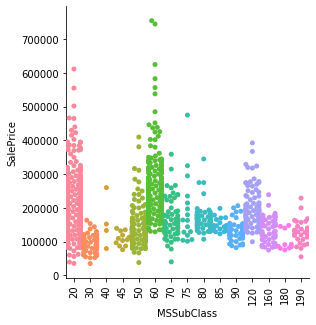

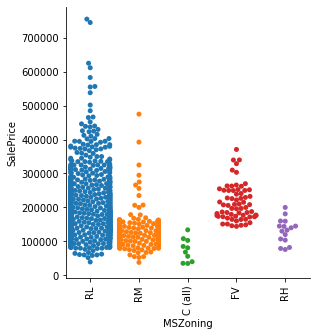

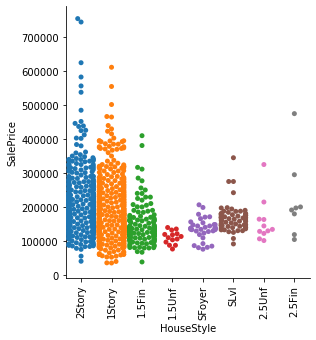

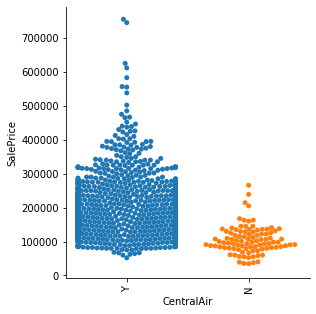

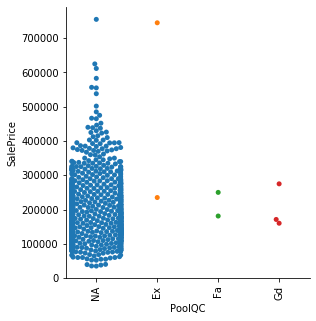

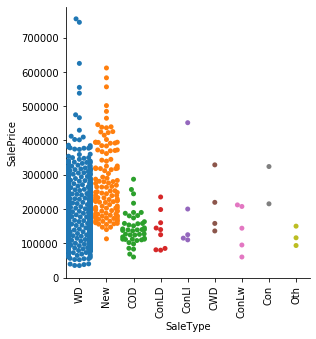

In [21]:
for element in ["MSSubClass", "MSZoning", "HouseStyle","CentralAir", "PoolQC", "SaleType"]:
    cat_plot = sns.catplot(y="SalePrice", x= element, kind="swarm", legend="full", data=train, height=4.5, aspect=3 / 3,);
    cat_plot.set_xticklabels(rotation=90)

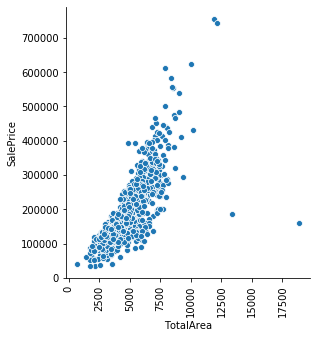

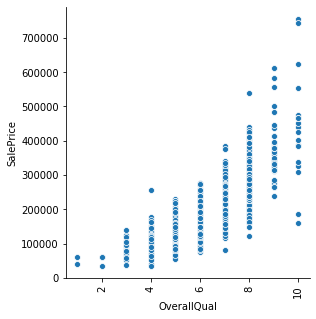

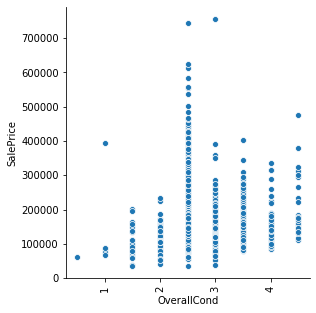

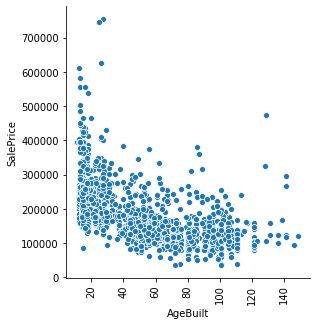

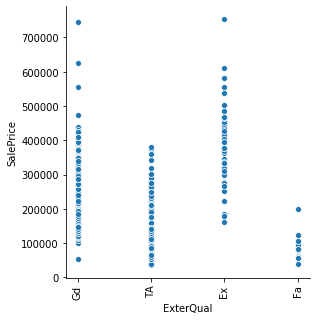

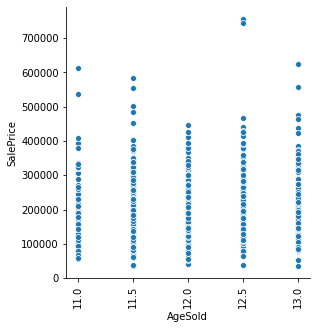

In [22]:
for element in ["TotalArea","OverallQual", "OverallCond", "AgeBuilt","ExterQual", "AgeSold"]:
    re_plot = sns.relplot(y="SalePrice", x= element, legend="full", data=train, height=4.5, aspect=3 / 3,);
    re_plot.set_xticklabels(rotation=90)

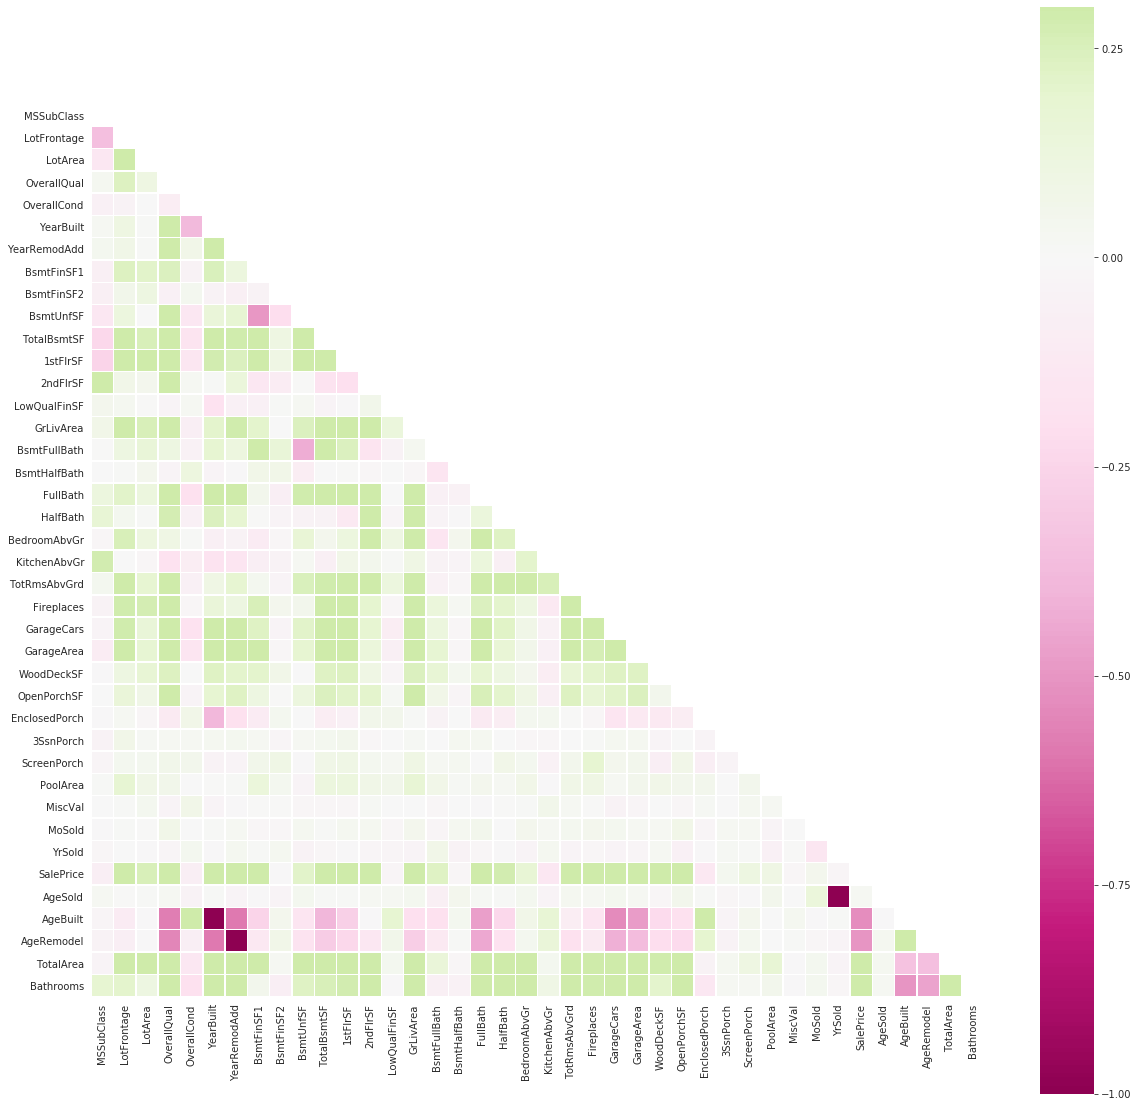

In [23]:
# Построим матрицу корреляций
corr = train.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(20, 20))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, center=0, square=True, linewidths=.5,cmap="PiYG")

### Работа с категориальными признаками

In [24]:
cat_features=[x for x in train.columns if train[x].dtype=="object"]
le= LabelEncoder()
for col in cat_features:
    if col in train.columns:
        i = train.columns.get_loc(col)
        train.iloc[:,i] = train.apply(lambda i:le.fit_transform(i.astype(str)), axis=0, result_type='expand')
    if col in test.columns:
        i = test.columns.get_loc(col)
        test.iloc[:,i] = test.apply(lambda i:le.fit_transform(i.astype(str)), axis=0, result_type='expand')

## Обучение моделей

In [25]:
# Напишем функцию rmse
def rmse(true, pred):
    return np.sqrt(mean_squared_error(true,pred))

In [26]:
# Разделим трейн на трейн и тест, для оценки моделей
X = train.drop('SalePrice', axis=1)
y = train['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.05, random_state=12345)
print("Размер обучающего датасета: {} столбцов, {} строк".format(X_train.shape[1], X_train.shape[0]))
print("Размер тестового датасета: {} столбцов, {} строк".format(X_test.shape[1], X_test.shape[0]))

Размер обучающего датасета: 84 столбцов, 1387 строк
Размер тестового датасета: 84 столбцов, 73 строк


Тестовая выборка намерено выбрана столь малая, для оценки итогов на адекватность перед отправкой на сабмит, т.к. тестовые данные не были доступны

### XGBRegressor

In [27]:
xgb_reg = XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3,min_child_weight=0, 
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:squarederror', 
                       nthread=-1, scale_pos_weight=1, seed=27,reg_alpha=0.00006)

In [28]:
xgb_reg.fit(X_train, y_train)

xgb_pred_test = xgb_reg.predict(X_test)
print(rmse(y_test, xgb_pred_test))

18012.913492624633


### Lasso

In [39]:
alphas = np.logspace(0, 0.2, 21)
n_folds = 5
parameters= {'alpha': alphas}
# Instantiate reg for gridsearch
lasso=Lasso()
# Conduct the gridsearch
lasso_reg = GridSearchCV(lasso, param_grid=parameters, scoring='neg_mean_squared_error', cv=n_folds)
#lasso_reg = Lasso(alpha= 0.0009)
lasso_reg.fit(X_train,y_train)
#lasso_pred_test = lasso_reg.predict(X_test)

print("LassoRegressor RMSE:",lasso_reg.best_score_)
print(lasso_reg.best_params_)

LassoRegressor RMSE: -1388103463.608872
{'alpha': 1.5848931924611136}


In [49]:
lasso_reg = Lasso(alpha= 0.0009)
lasso_reg.fit(X_train,y_train)

# Predict on the test set from our training set
y_pred = lasso_reg.predict(X_test)
print("LassoRegressor RMSE:",rmse(y_test,y_pred))

LassoRegressor RMSE: 25265.55163091995


### RandomForestRegressor

In [33]:
rf_reg = RandomForestRegressor(bootstrap = True, max_depth = 80, max_features = 'auto', min_samples_leaf = 3,
                               min_samples_split = 8, n_estimators = 300, n_jobs=-1, random_state=12)
rf_reg.fit(X_train, y_train)

y_pred_rf = rf_reg.predict(X_test)
print("RandomForestRegressor RMSE:",rmse(y_test, y_pred_rf))

RandomForestRegressor RMSE: 21216.163476041922


### LGBMRegressor

In [34]:
lgbm_reg = lgbm.LGBMRegressor(
    objective='regression',
    num_leaves=4,
    learning_rate=0.01,
    n_estimators=5000,
    max_bin=200,
    bagging_fraction=0.75,
    bagging_freq=5,
    bagging_seed=7,
    feature_fraction=0.2,
    feature_fraction_seed=7,
    verbose=-1,
    #min_data_in_leaf=2,
    #min_sum_hessian_in_leaf=11
)
lgbm_reg.fit(X_train, y_train)

# Predict on the test set from our training set

y_pred_test = lgbm_reg.predict(X_test)
print("LGBMRegressor RMSE:",(rmse(y_test, y_pred_test)))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
LGBMRegressor RMSE: 19451.6085083778


### STACKED REGRESSION

In [36]:
stregr = StackingRegressor(regressors=[rf_reg, lgbm_reg,xgb_reg],meta_regressor=xgb_reg, use_features_in_secondary=True )
stack_reg=stregr.fit(X_train, y_train)
y_pred_test = stack_reg.predict(X_test)
print("StackedRegressor RMSE:",np.sqrt(mean_squared_error(y_test, y_pred_test)))

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
StackedRegressor RMSE: 17676.811323055765


RMSLE сабмита на каггле составил = 0.13006


In [37]:
X_train2 = train.drop('SalePrice', axis=1)
y_train2 = train['SalePrice']

tack_reg=stregr.fit(X_train2, y_train2)
y_pred_test = stack_reg.predict(test)

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75


In [38]:
sub1 = pd.DataFrame()
sub1['Id'] = ids
sub1['SalePrice'] = y_pred_test
sub1.to_csv('submiss_new.csv',index=False)

## Вывод

Этап анализа данных:
* Датафрйем состоит из 81 столбца и 1.5 тыс. строк
* Присутствует множ-во признаков с пропусками, везде разная доля пропущенных данных
* Часть пропущенных значений мы заполнили лин. регрессией, часть категориальных пропусков заполнили смысловыми значениями, часть пропусков дропнули
* Генерация признаков: Добавили кол-во прошедших лет с момента последней продажи, ремонта и постройки дома, также добавили признаки, связанные с площадью дома
* Рассмотрели распроделение различных пар признаков и построили матрицу корреляции

Построение моделей:
* Наилучшего результата я добился методом проб и ошибок, используя ансамбль моделей random forrest regression, lightgbm regressor и xgboost regressor
* Результат сабмита каггла: RSMLE = 0.13006 (top 29%)
